(array([532., 331., 217., 133.,  86.,  59.,  46.,  40.,  19.,  17.,   7.,
          3.,   4.,   0.,   3.,   1.,   1.,   0.,   0.,   1.]),
 array([5.46113990e-06, 4.28570346e-03, 8.56594578e-03, 1.28461881e-02,
        1.71264304e-02, 2.14066727e-02, 2.56869151e-02, 2.99671574e-02,
        3.42473997e-02, 3.85276420e-02, 4.28078843e-02, 4.70881267e-02,
        5.13683690e-02, 5.56486113e-02, 5.99288536e-02, 6.42090959e-02,
        6.84893383e-02, 7.27695806e-02, 7.70498229e-02, 8.13300652e-02,
        8.56103075e-02]),
 <BarContainer object of 20 artists>)

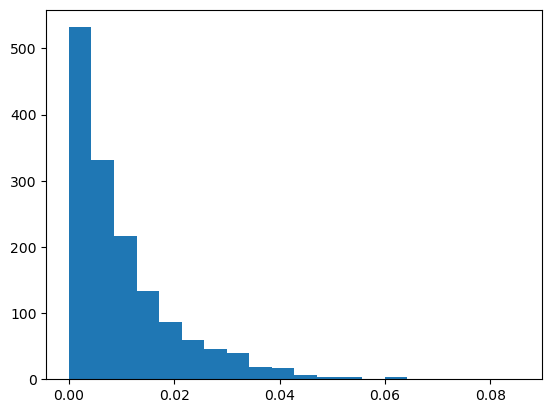

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
rate = 100  # Hz
T = 10.0  # seconds
np.random.seed(0)

# Step 1: Generate exponential interspike intervals
isi = np.random.exponential(scale=1/rate, size=int(rate * T * 1.5))  # oversample to be safe

# Step 2: Compute cumulative sum to get spike times
spike_times = np.cumsum(isi)
spike_times = spike_times[spike_times < T]  # keep spikes within duration

plt.hist(isi, bins=20)

In [5]:
spike_times.shape

(997,)

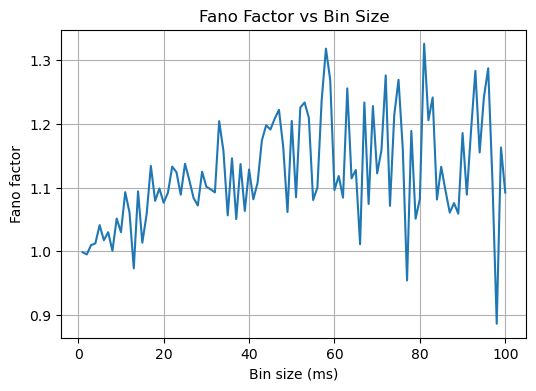

CV:  1.0247781513248424


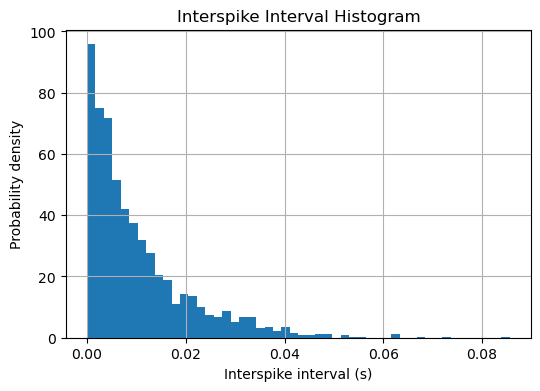

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
# Parameters
rate = 100  # Hz
T = 10.0  # seconds
np.random.seed(0)

# Step 1: Generate exponential interspike intervals
isi = np.random.exponential(scale=1/rate, size=int(rate * T * 1.5))  # oversample to be safe

# Step 2: Compute cumulative sum to get spike times
spike_times = np.cumsum(isi)
spike_times = spike_times[spike_times < T]  # keep spikes within duration

def bin_spike_times(spike_times, T, bin_size_ms):
    bin_size_s = bin_size_ms / 1000.0
    num_bins = int(np.floor(T / bin_size_s))
    bins = np.linspace(0, T, num_bins + 1)
    spike_counts, _ = np.histogram(spike_times, bins=bins)
    return spike_counts

# Your simulated spike_times and T should already be defined
fano_factors = []
bin_sizes = range(1, 101)  # from 1 ms to 100 ms
for bin_size in bin_sizes:
    binned = bin_spike_times(spike_times, T, bin_size)
    if np.mean(binned) > 0:  # avoid division by zero
        fano = np.var(binned) / np.mean(binned)
    else:
        fano = np.nan
    fano_factors.append(fano)
# Plot
plt.figure(figsize=(6,4))
plt.plot(bin_sizes, fano_factors)
plt.xlabel("Bin size (ms)")
plt.ylabel("Fano factor")
plt.title("Fano Factor vs Bin Size")
plt.grid(True)
plt.show()

print('CV: ', np.std(isi)/np.mean(isi))

plt.figure(figsize=(6,4))
plt.hist(isi, bins=50, density=True)
plt.xlabel("Interspike interval (s)")
plt.ylabel("Probability density")
plt.title("Interspike Interval Histogram")
plt.grid(True)
plt.show()


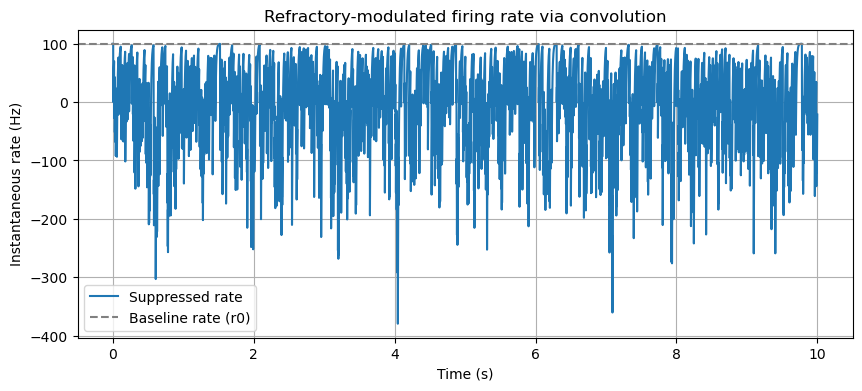

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Use spike_times from previous simulation
rate = 100  # Hz
T = 10.0    # seconds
dt = 0.001  # 1 ms resolution
time = np.arange(0, T, dt)

# Step 1: Convert spike times to discrete-time spike train
spike_train = np.zeros_like(time)
spike_indices = (spike_times / dt).astype(int)
spike_indices = spike_indices[spike_indices < len(time)]  # avoid overflow
spike_train[spike_indices] = 1

# Step 2: Create exponential decay kernel
tau_ref = 0.01  # 10 ms refractory time constant
kernel_duration = 0.1  # seconds (to let it decay sufficiently)
kernel_t = np.arange(0, kernel_duration, dt)
exp_kernel = np.exp(-kernel_t / tau_ref)

# Step 3: Convolve spike train with kernel
filtered = convolve(spike_train, exp_kernel, mode='full')[:len(time)]

# Step 4: Compute rate(t) = r0 * (1 - exp_decay_sum)
rate_t = rate * (1 - filtered)

# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(time, rate_t, label='Suppressed rate')
plt.axhline(rate, color='gray', linestyle='--', label='Baseline rate (r0)')
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous rate (Hz)")
plt.title("Refractory-modulated firing rate via convolution")
plt.legend()
plt.grid(True)
plt.show()


Generated 629 spikes


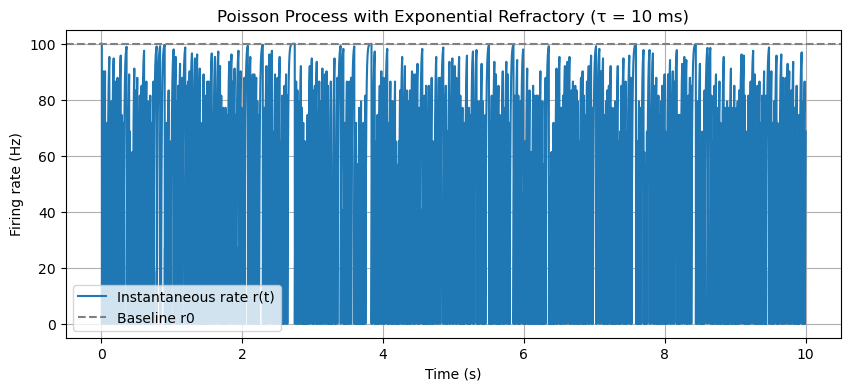

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r0 = 100         # baseline rate in Hz
T = 10.0         # total duration in seconds
dt = 0.001       # time step in seconds (1 ms)
tau_ref = 0.01   # refractory time constant in seconds (10 ms)

# Time array
time = np.arange(0, T, dt)
n_steps = len(time)

# Initialize arrays
r_t = np.zeros(n_steps)
r_t[0] = r0
spike_train = np.zeros(n_steps)

# Simulation loop
for t in range(1, n_steps):
    # Recover rate
    r_t[t] = r_t[t-1] + dt * (r0 - r_t[t-1]) / tau_ref

    # Spike probability
    p_spike = r_t[t] * dt  # unitless

    # Draw spike
    if np.random.rand() < p_spike:
        spike_train[t] = 1
        r_t[t] = 0  # reset rate

# Extract spike times
spike_times = time[spike_train == 1]
print(f"Generated {len(spike_times)} spikes")

# Plot the firing rate over time
plt.figure(figsize=(10, 4))
plt.plot(time, r_t, label='Instantaneous rate r(t)')
plt.axhline(r0, color='gray', linestyle='--', label='Baseline r0')
plt.xlabel("Time (s)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"Poisson Process with Exponential Refractory (τ = {tau_ref*1000:.0f} ms)")
plt.legend()
plt.grid(True)
plt.show()
